# **Data Understanding**

Dalam proyek dunia nyata, data jarang sekali tersedia dalam satu file yang bersih. Seringkali, data tersebar di berbagai sistem, database, atau bahkan lokasi geografis—sebuah fenomena yang dikenal sebagai **data silos**. Dengan data petal di **MySQL** dan sepal di **PostgreSQL** (keduanya di platform Aiven).

## **1. Konfigurasi**

Menggunakan file `.env` untuk menyimpan informasi sensitif di luar *script* Python. Pustaka `python-dotenv` akan digunakan untuk memuat variabel-variabel ini ke dalam lingkungan kerja.

  * **Implementasi**:

    1.  Buat sebuah file bernama `.env` di direktori proyek.
    2.  Isi file tersebut dengan format berikut, menggunakan detail koneksi dari *dashboard* Aiven Anda:

    <!-- end list -->

    ```python
    # Kredensial Aiven untuk PostgreSQL
    PG_USER="username_pg"
    PG_PASSWORD="password_pg"
    PG_HOST="host.aivencloud.com"
    PG_PORT="12345"
    PG_DBNAME="database_name_pg"

    # Kredensial Aiven untuk MySQL
    MYSQL_USER="username_mysql"
    MYSQL_PASSWORD="password_mysql"
    MYSQL_HOST="host.aivencloud.com"
    MYSQL_PORT="54321"
    MYSQL_DBNAME="database_name_mysql"
    ```

## **2. Koneksi Database**

Untuk berinteraksi dengan berbagai jenis database SQL dari Python secara seragam, akan menggunakan **SQLAlchemy**, **psycopg2-binary**, dan **mysql-connector-python**. Pustaka ini menyediakan sebuah *Object-Relational Mapper* (ORM) dan *engine* koneksi yang mengabstraksi detail spesifik dari setiap dialek SQL.

Membuat dua "engine" koneksi terpisah. Setiap *engine* mengelola *pool* koneksi ke databasenya masing-masing, memungkinkan eksekusi kueri yang efisien.

  * **Implementasi (Kode Python)**:
    

In [1]:
    import os
    import pandas as pd
    from dotenv import load_dotenv
    from sqlalchemy import create_engine, text

    # Muat variabel dari file .env ke dalam environment
    load_dotenv()

    # Koneksi ke PostgreSQL untuk data Sepal
    try:
        pg_uri = (
            f"postgresql+psycopg2://{os.getenv('PG_USER')}:{os.getenv('PG_PASSWORD')}"
            f"@{os.getenv('PG_HOST')}:{os.getenv('PG_PORT')}/{os.getenv('PG_DBNAME')}"
        )
        pg_engine = create_engine(pg_uri)
        print(" Koneksi ke PostgreSQL berhasil dibangun.")
    except Exception as e:
        print(f" Gagal terkoneksi ke PostgreSQL: {e}")


    # Koneksi ke MySQL untuk data Petal
    try:
        mysql_uri = (
            f"mysql+mysqlconnector://{os.getenv('MYSQL_USER')}:{os.getenv('MYSQL_PASSWORD')}"
            f"@{os.getenv('MYSQL_HOST')}:{os.getenv('MYSQL_PORT')}/{os.getenv('MYSQL_DBNAME')}"
        )
        mysql_engine = create_engine(mysql_uri)
        print(" Koneksi ke MySQL berhasil dibangun.")
    except Exception as e:
        print(f" Gagal terkoneksi ke MySQL: {e}")

 Koneksi ke PostgreSQL berhasil dibangun.
 Koneksi ke MySQL berhasil dibangun.




Kode di atas menggunakan *f-string* untuk membangun URI koneksi secara dinamis dari variabel lingkungan. Penggunaan blok `try...except` adalah praktik yang baik untuk menangani potensi kegagalan koneksi secara elegan.

## **3. Ekstraksi data**

Dengan *engine* yang sudah siap, kini bisa mengeksekusi kueri untuk menarik data dan kemudian menggabungkannya.

Menggunakan fungsi `pd.read_sql` dari pandas yang sangat efisien, yang mengambil kueri SQL dan sebuah *engine* koneksi sebagai input, lalu langsung mengembalikan hasilnya sebagai DataFrame. Kedua tabel memiliki **kolom kunci yang sama** (misalnya, `id`) untuk proses penggabungan (*join*).

* **Implementasi (Kode Python)**:

In [6]:
    # nama tabel adalah 'sepal_data' di PostgreSQL dan 'petal_data' di MySQL
    query_sepal = text("SELECT id, sepal_length, sepal_width, species FROM sepal_data")
    query_petal = text("SELECT id, petal_length, petal_width FROM petal_data")

    # Eksekusi kueri dan muat ke DataFrame
    sepal_df = pd.read_sql(query_sepal, pg_engine)
    petal_df = pd.read_sql(query_petal, mysql_engine)

    print("Data Sepal")
    print(sepal_df.to_string())
    print("\nData Petal")
    print(petal_df.to_string())

    # Gabungkan (merge) kedua DataFrame berdasarkan kunci primer 'id'
    # Menggunakan 'inner join' untuk memastikan hanya baris yang cocok di kedua tabel yang diambil
    iris_df = pd.merge(sepal_df, petal_df, on='id', how='inner')

    print("\n Dataset Iris")
    print(iris_df.to_string())

Data Sepal
      id  sepal_length  sepal_width          species
0      1           5.1          3.5      Iris-setosa
1      2           4.9          3.0      Iris-setosa
2      3           4.7          3.2      Iris-setosa
3      4           4.6          3.1      Iris-setosa
4      5           5.0          3.6      Iris-setosa
5      6           5.4          3.9      Iris-setosa
6      7           4.6          3.4      Iris-setosa
7      8           5.0          3.4      Iris-setosa
8      9           4.4          2.9      Iris-setosa
9     10           4.9          3.1      Iris-setosa
10    11           5.4          3.7      Iris-setosa
11    12           4.8          3.4      Iris-setosa
12    13           4.8          3.0      Iris-setosa
13    14           4.3          3.0      Iris-setosa
14    15           5.8          4.0      Iris-setosa
15    16           5.7          4.4      Iris-setosa
16    17           5.4          3.9      Iris-setosa
17    18           5.1          3.5







## **4. Verifikasi data**

Setelah penggabungan, sangat penting untuk melakukan verifikasi cepat untuk memastikan prosesnya berjalan sesuai harapan.

Memeriksa dimensi, tipe data, dan nilai-nilai yang hilang dari DataFrame hasil gabungan.

  * **Implementasi (Kode Python)**:



 
  



In [8]:


# 1. Periksa dimensi data. Seharusnya ada 150 baris dan 6 kolom
# (sid, sepal_length, sepal_width, species, petal_length, petal_width)
print(f"Dimensi DataFrame: {iris_df.shape}")

# 2. Periksa informasi umum, termasuk tipe data dan nilai non-null
# penting untuk memastikan pandas menginterpretasikan tipe data (numerik, kategorikal) dengan benar.
print("\nInfo DataFrame:")
iris_df.info()

Dimensi DataFrame: (150, 6)

Info DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            150 non-null    int64  
 1   sepal_length  150 non-null    float64
 2   sepal_width   150 non-null    float64
 3   species       150 non-null    object 
 4   petal_length  150 non-null    float64
 5   petal_width   150 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB



Output dari `.info()` mengonfirmasi bahwa tidak ada data yang hilang selama proses *join* dan tipe data untuk setiap kolom sudah sesuai (misalnya, `float64` untuk ukuran, `object` untuk `species`). Jika jumlah baris kurang dari 150, ini bisa mengindikasikan adanya ketidakcocokan `id` antara kedua database.


## **5. Eksplorasi Data (Python)**

Setelah berhasil mengintegrasikan data dari sumber MySQL dan PostgreSQL, langkah selanjutnya adalah melakukan investigasi mendalam terhadap dataset `iris_df` yang telah terunifikasi. Fase ini bertujuan untuk melampaui observasi permukaan dan menggunakan perangkat statistik serta visualisasi canggih dalam Python untuk membangun pemahaman yang robust tentang struktur, sebaran, dan hubungan dalam data.

### **1. Analisis Sebaran Data**

Menguji asumsi statistik dan mengkuantifikasi bentuk sebaran data, sebuah langkah penting sebelum pemodelan.

#### **A. Uji Normalitas (Shapiro-Wilk Test)**

Banyak algoritma bekerja paling baik dengan data yang berdistribusi normal. Menguji hipotesis nol ($H\_0$) bahwa data berasal dari sebaran normal.

  * **Implementasi**:

 
   

In [12]:
from scipy.stats import shapiro

print("--- Uji Normalitas Shapiro-Wilk untuk 'Petal Width' ---")
for species_name in iris_df['species'].unique():
    subset = iris_df[iris_df['species'] == species_name]
    stat, p_value = shapiro(subset['petal_width'])
        
    print(f"\nSpesies: {species_name}")
    print(f"  - P-value: {p_value:.4f}")
        
    if p_value > 0.05:
        print("  - Kesimpulan: Data kemungkinan berdistribusi normal.")
    else:
        print("  - Kesimpulan: Data kemungkinan TIDAK berdistribusi normal.")

--- Uji Normalitas Shapiro-Wilk untuk 'Petal Width' ---

Spesies: Iris-setosa
  - P-value: 0.0000
  - Kesimpulan: Data kemungkinan TIDAK berdistribusi normal.

Spesies: Iris-versicolor
  - P-value: 0.0273
  - Kesimpulan: Data kemungkinan TIDAK berdistribusi normal.

Spesies: Iris-virginica
  - P-value: 0.0870
  - Kesimpulan: Data kemungkinan berdistribusi normal.


Penemuan untuk fitur petal_width, distribusi pada Iris-setosa dan Iris-versicolor secara statistik tidak normal (p < 0.05), sementara Iris-virginica normal (p > 0.05).

Ini adalah temuan penting. Ini mengindikasikan bahwa asumsi normalitas tidak berlaku secara universal di seluruh subset data. Konsekuensinya, model-model non-parametrik (yang tidak membuat asumsi kuat tentang distribusi data) seperti Decision Trees, Random Forest, K-Nearest Neighbors (KNN), dan Support Vector Machines (SVM) kemungkinan akan lebih robust dan menjadi kandidat model yang kuat untuk dataset ini.


### **2. Analisis Perbandingan Antar Kelas (Spesies)**

Memahami secara mendalam bagaimana fitur-fitur membedakan antar spesies.

#### **A. Visualisasi Perbandingan Distribusi (Violin Plots)**

*Violin plot* adalah kombinasi dari *box plot* dan *Kernel Density Estimate* (KDE), yang memberikan gambaran ringkas namun kaya tentang distribusi data.

  * **Implementasi**:


   

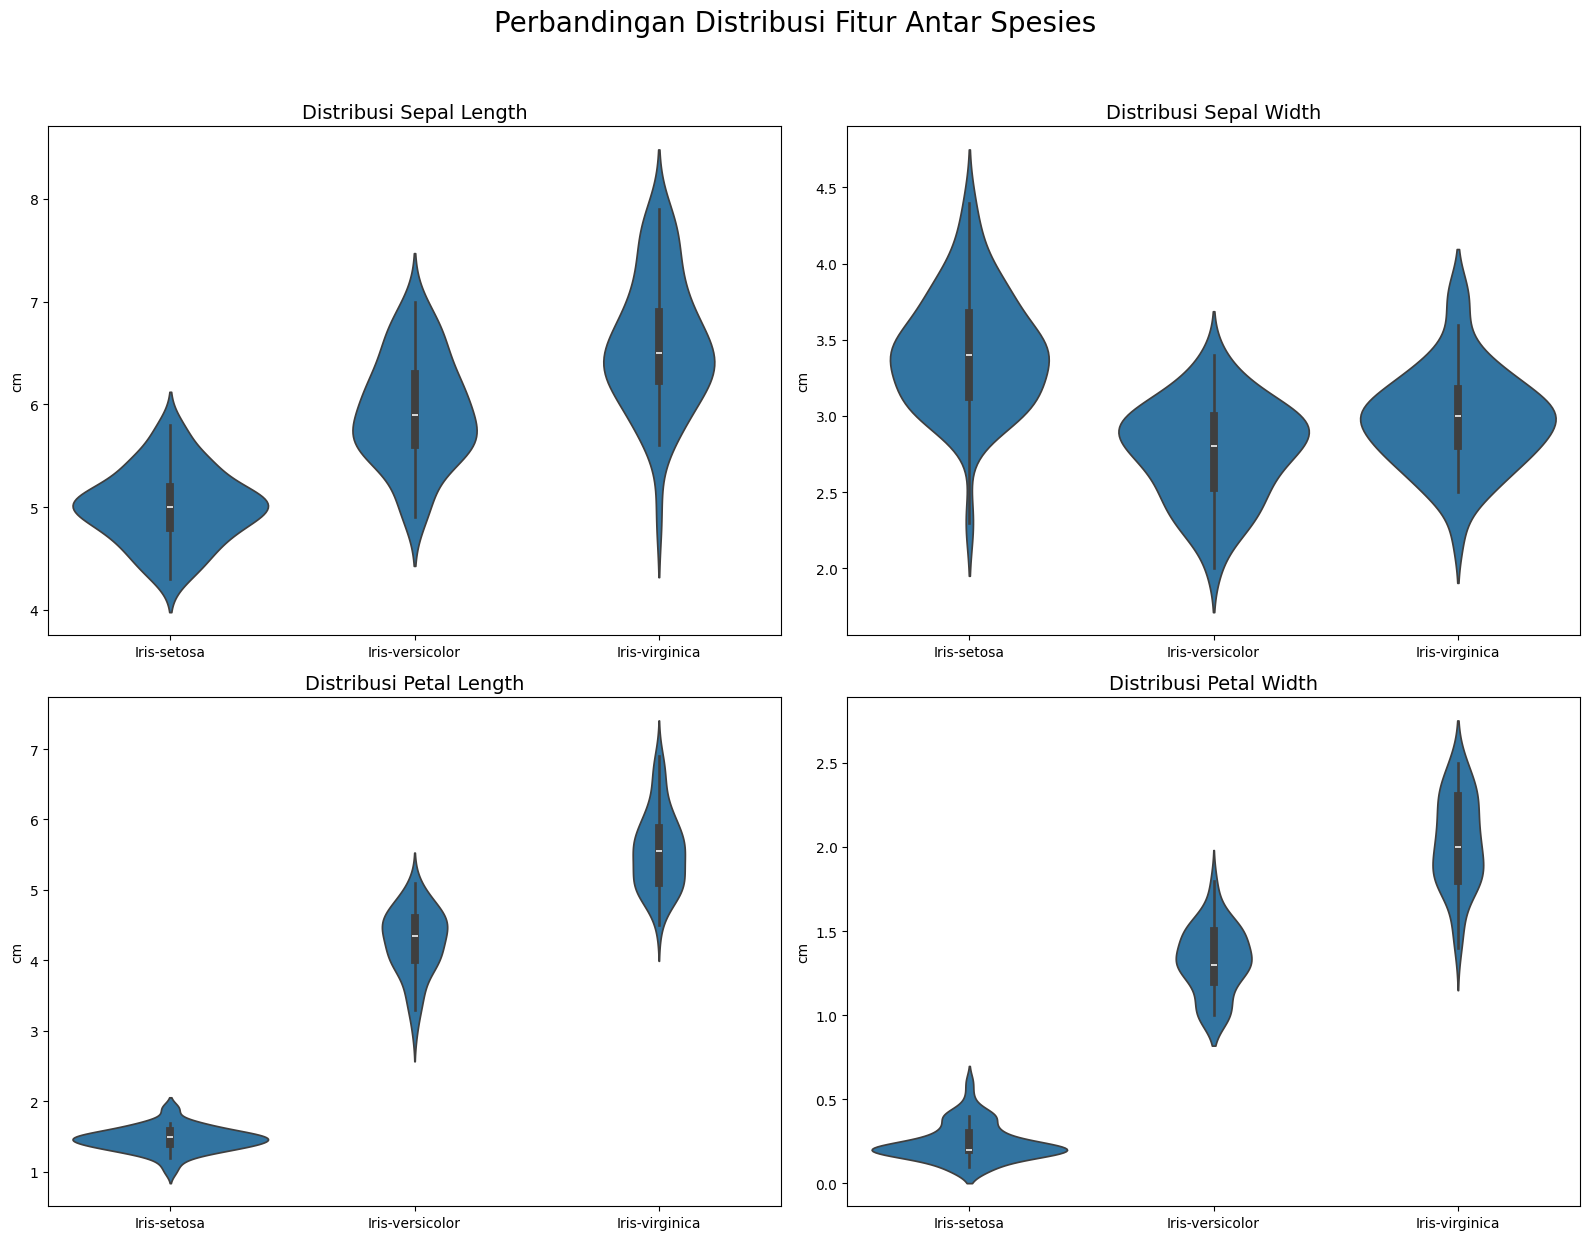

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Perbandingan Distribusi Fitur Antar Spesies', fontsize=20, y=1.03)

# List fitur untuk di-plot
features_to_plot = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
ax_flat = axes.flatten()

for i, feature in enumerate(features_to_plot):
    sns.violinplot(ax=ax_flat[i], data=iris_df, x='species', y=feature)
    ax_flat[i].set_title(f'Distribusi {feature.replace("_", " ").title()}', fontsize=14)
    ax_flat[i].set_xlabel('')
    ax_flat[i].set_ylabel('cm')

plt.tight_layout()
plt.show()

Gambar dengan jelas mendukung temuan statistik di atas.

* Plot untuk petal_length dan petal_width (baris bawah) secara dramatis menunjukkan isolasi penuh dari Iris-setosa, yang memiliki distribusi yang sangat sempit dan terpisah di nilai-nilai rendah.

* Plot untuk fitur sepal (baris atas) menunjukkan tumpang tindih yang lebih besar antar ketiga spesies, meskipun masih ada pola yang bisa dibedakan (misalnya, sepal_width Setosa cenderung lebih besar).

* Bentuk "violin" yang berbeda-beda antar spesies untuk fitur yang sama secara visual mengkonfirmasi mengapa beberapa di antaranya tidak lolos uji normalitas.

#### **B. Validasi Statistik Perbedaan Rata-rata (ANOVA)**

  * **Implementasi**:

In [16]:
from scipy.stats import f_oneway

# Ekstrak data petal length untuk setiap spesies
grouped_data = [group['petal_length'].values for name, group in iris_df.groupby('species')]

# Lakukan uji One-Way ANOVA
f_stat, p_value_anova = f_oneway(*grouped_data)

print(f"--- Uji ANOVA untuk 'Petal Length' antar 3 Spesies ---")
print(f"  - F-statistic: {f_stat:.2f}")
print(f"  - P-value: {p_value_anova}")

--- Uji ANOVA untuk 'Petal Length' antar 3 Spesies ---
  - F-statistic: 1179.03
  - P-value: 3.0519758018278374e-91


Nilai F-statistic yang sangat besar (1179.03) dan P-value yang secara efektif nol (3.05×10 
−91
 ) memberikan bukti statistik yang sangat kuat untuk menolak hipotesis nol.

Ini secara definitif mengkonfirmasi bahwa perbedaan rata-rata petal_length antar ketiga spesies bukan karena kebetulan, melainkan sangat signifikan. Ini memvalidasi petal_length bukan hanya sebagai fitur yang baik, tetapi sebagai fitur pembeda utama dalam dataset ini. Wawasan yang sama kemungkinan besar berlaku untuk petal_width.

### **3. Analisis Struktur & Dimensi Data**

Memproyeksikan data 4-dimensi ke dalam ruang 2-dimensi untuk memvisualisasikan struktur pemisahan kelas secara keseluruhan.

#### **A. Visualisasi dengan Reduksi Dimensi (Principal Component Analysis - PCA)**

PCA menemukan kombinasi fitur terbaik yang menangkap varians data paling maksimal, memungkinkan dapat "melihat" dataset dalam 2D.

  * **Implementasi**:

    

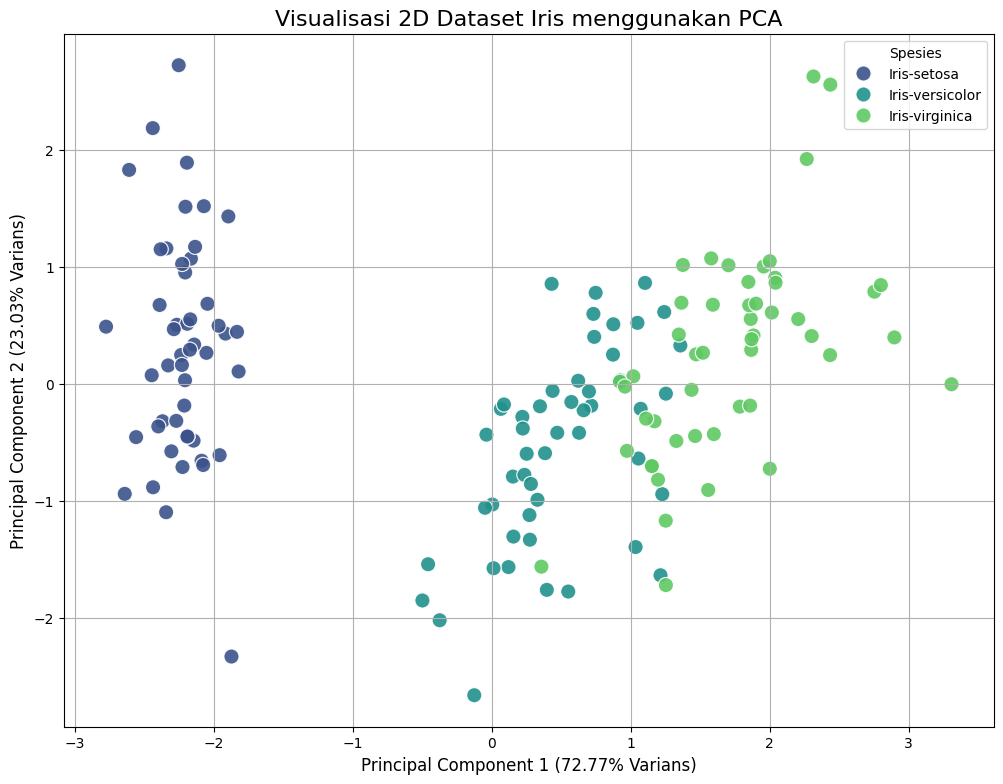

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1. Pisahkan fitur (X) dan target (y)
features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
X = iris_df.loc[:, features].values
y = iris_df.loc[:, 'species'].values

# 2. Standarisasi fitur (wajib untuk PCA)
X_scaled = StandardScaler().fit_transform(X)

# 3. Terapkan PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=['PC 1', 'PC 2'])
pca_df['species'] = y

# 4. Hitung varians yang dijelaskan
explained_variance = pca.explained_variance_ratio_ * 100

# 5. Visualisasikan
plt.figure(figsize=(12, 9))
sns.scatterplot(x='PC 1', y='PC 2', hue='species', data=pca_df, s=120, alpha=0.9, palette='viridis')

plt.title('Visualisasi 2D Dataset Iris menggunakan PCA', fontsize=16)
plt.xlabel(f'Principal Component 1 ({explained_variance[0]:.2f}% Varians)', fontsize=12)
plt.ylabel(f'Principal Component 2 ({explained_variance[1]:.2f}% Varians)', fontsize=12)
plt.legend(title='Spesies')
plt.grid(True)
plt.show()

* Plot ini menunjukkan bahwa dua Komponen Utama pertama secara kumulatif menjelaskan ~95.8% dari total varians data (PC1: 72.77% + PC2: 23.03%). Ini sangat tinggi dan berarti plot 2D ini adalah representasi yang sangat akurat dari struktur data 4D asli.

* Separabilitas Linear: Klaster Iris-setosa terpisah secara sempurna dan berada jauh dari dua klaster lainnya. Ini mengindikasikan bahwa sebuah model linear sederhana pun akan mampu mengklasifikasikan Setosa dengan akurasi mendekati 100%.

* Tumpang tindih (overlap) yang kecil namun ada antara Iris-versicolor dan Iris-virginica adalah "zona tantangan". Di sinilah kemampuan model untuk menemukan batas keputusan yang optimal akan benar-benar diuji.

## **6. Ekplorasi Data (Power BI)**
### **1. Distribusi tipe numerik**
![image.png](avg_n.png)
### **2. Distribusi tipe kategorikal**
![image.png](avg_k.png)
### **3. Rata-rata**
#### **A. Fitur**
![image.png](avg_f.png)
#### **B. Fitur per spesies**
![image.png](avg_p.png)
### **4. Minimum**
#### **A. Fitur**
![image.png](min_f.png)
#### **B. Fitur per spesies**
![image.png](min_p.png)
### **5. Maximum**
#### **A. Fitur**
![image.png](max_f.png)
#### **B. Fitur per spesies**
![image.png](max_p.png)
### **6. Standar Devisiasi**
#### **A. Fitur**
![image.png](stan_f.png)
#### **B. Fitur per spesies**
![image.png](stan_p.png)
### **6. Median**
#### **A. Fitur**
![image.png](med_f.png)
#### **B. Fitur per spesies**
![image.png](med_p.png)